# Deep Learning in Practice : TP3

# Practical Session on Graph Neural Networks

**Student : Théo Di Piazza** - theo.dipiazza@gmail.com

**Master : MVA ENS Paris-Saclay**

**TP made by : Matthieu Nastorg**

**Remark :** Please check that diagramm_architecture.png is in your working directory.

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/ 
#####################################################
import torch 

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 71.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 68.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 53.7

### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

In [3]:
# Import more libraries
import torch.nn.init as init
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [4]:
### LOAD DATASETS

BATCH_SIZE = 2 

# Train Dataset
train_dataset = PPI(root="", split='train')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split='val')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Extracting ./ppi.zip
Processing...


Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


Done!


In [5]:
# print some informations to understand how pytorch_geometric works
for i, train_batch in enumerate(train_dataloader):
  break

print(f'type(train_batch): {type(train_batch)}')
print(f'len(train_batch): {len(train_batch)}')

print(f'\nDisplay first sample of the first batch: ')
print(f'> train_batch[0]: {train_batch[0]}')
print(f'>> There are {train_batch[0].x.shape[0]} nodes and each node has {train_batch[0].x.shape[1]} features.')
print(f'>> There are {train_batch[0].y.shape[0]} nodes and each node has {train_batch[0].y.shape[1]} labels.')
print(f'>> There are {train_batch[0].edge_index.shape[1]} edges.')

type(train_batch): <class 'torch_geometric.data.batch.DataBatch'>
len(train_batch): 2

Display first sample of the first batch: 
> train_batch[0]: Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
>> There are 1767 nodes and each node has 50 features.
>> There are 1767 nodes and each node has 121 labels.
>> There are 32318 edges.


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [6]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):

        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [7]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [8]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):

    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Let's train this model !

In [9]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(  input_size = n_features, 
                                hidden_size = 256, 
                                output_size = n_classes).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(basic_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.6366
F1-Score: 0.4581
Epoch 00002 | Loss: 0.5808
Epoch 00003 | Loss: 0.5622
Epoch 00004 | Loss: 0.5554
Epoch 00005 | Loss: 0.5502
Epoch 00006 | Loss: 0.5460
F1-Score: 0.5155
Epoch 00007 | Loss: 0.5424
Epoch 00008 | Loss: 0.5380
Epoch 00009 | Loss: 0.5339
Epoch 00010 | Loss: 0.5309
Epoch 00011 | Loss: 0.5282
F1-Score: 0.5169
Epoch 00012 | Loss: 0.5255
Epoch 00013 | Loss: 0.5231
Epoch 00014 | Loss: 0.5208
Epoch 00015 | Loss: 0.5184
Epoch 00016 | Loss: 0.5162
F1-Score: 0.5347
Epoch 00017 | Loss: 0.5139
Epoch 00018 | Loss: 0.5118
Epoch 00019 | Loss: 0.5097
Epoch 00020 | Loss: 0.5077
Epoch 00021 | Loss: 0.5057
F1-Score: 0.5448
Epoch 00022 | Loss: 0.5039
Epoch 00023 | Loss: 0.5023
Epoch 00024 | Loss: 0.5010
Epoch 00025 | Loss: 0.4998
Epoch 00026 | Loss: 0.4991
F1-Score: 0.5167
Epoch 00027 | Loss: 0.4967
Epoch 00028 | Loss: 0.4942
Epoch 00029 | Loss: 0.4923
Epoch 00030 | Loss: 0.4902
Epoch 00031 | Loss: 0.4878
F1-Score: 0.5560
Epoch 00032 | Loss: 0.4863
Ep

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6427


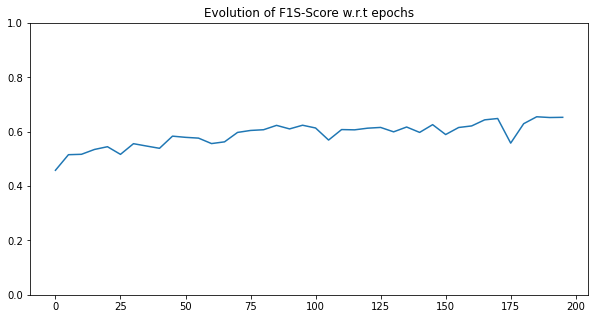

In [10]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))

### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores) :
    plt.figure(figsize=[10,5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [11]:
class StudentModel(nn.Module):
  def __init__(self, input_size=50, hidden_size=256, output_size=121, num_heads=4, xavier_init=False):
      '''
      initialization of the network
        input_size : number of nodes
        hidden_size : hidden size of layers
        output_size : number of features to predict
        num_heads : number of attention heads for attention mecanism
        xavier_init : True to have Xavier initialization for weights
      '''
      super().__init__()
      
      # GAT layers
      self.graphgat1 = graphnn.GATConv(input_size, hidden_size, heads = 4)
      self.graphgat2 = graphnn.GATConv(4*hidden_size, hidden_size, heads = 4)
      self.graphgat_classifier = graphnn.GATConv(4*hidden_size, output_size, heads = 6, concat=False)
      
      # LINEAR layers, skip connection for intermediate layers
      self.linear1 = nn.Linear(input_size, 4*hidden_size)
      self.linear2 = nn.Linear(4*hidden_size, 4*hidden_size)
      self.linear_classifier = nn.Linear(4*hidden_size, output_size)

      # xavier initialization
      if(xavier_init):
        for layer in [self.graphgat1, self.graphgat2, self.graphgat3]:
            init.xavier_uniform_(layer.weight)

      # activation layers
      self.elu = nn.ELU()
      
  def forward(self, x, edge_index):
      '''
      forward propagation of the network
         x : nodes features (number of nodes, number of features)
         edge_index : edges of the graph (2, number of edges)
      '''
      # first layer : GAT + ELU with skip connection
      x = self.graphgat1(x, edge_index) + self.linear1(x)
      x = self.elu(x)
      # second layer : GAT + ELU with skip connection
      x = self.graphgat2(x, edge_index) + self.linear2(x)
      x = self.elu(x)
      # third layer : classification
      x = self.graphgat_classifier(x, edge_index) + self.linear_classifier(x)

      return x

Let's train your model !

In [12]:
## Student model

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\nDevice: ", device)

### parameters and model
input_size, hidden_size, output_size = 50, 256, 121
xavier_init = False
student_model = StudentModel(input_size, hidden_size, output_size).to(device)

### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### Max number of epochs
max_epochs = 200

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)


Device:  cuda
Epoch 00001 | Loss: 0.9383
F1-Score: 0.4505
Epoch 00002 | Loss: 0.5897
Epoch 00003 | Loss: 0.5258
Epoch 00004 | Loss: 0.4991
Epoch 00005 | Loss: 0.4775
Epoch 00006 | Loss: 0.4560
F1-Score: 0.5952
Epoch 00007 | Loss: 0.4350
Epoch 00008 | Loss: 0.4187
Epoch 00009 | Loss: 0.3943
Epoch 00010 | Loss: 0.3655
Epoch 00011 | Loss: 0.3419
F1-Score: 0.7319
Epoch 00012 | Loss: 0.3187
Epoch 00013 | Loss: 0.2942
Epoch 00014 | Loss: 0.2706
Epoch 00015 | Loss: 0.2473
Epoch 00016 | Loss: 0.2229
F1-Score: 0.8263
Epoch 00017 | Loss: 0.2021
Epoch 00018 | Loss: 0.1854
Epoch 00019 | Loss: 0.1696
Epoch 00020 | Loss: 0.1554
Epoch 00021 | Loss: 0.1439
F1-Score: 0.8883
Epoch 00022 | Loss: 0.1318
Epoch 00023 | Loss: 0.1207
Epoch 00024 | Loss: 0.1134
Epoch 00025 | Loss: 0.1054
Epoch 00026 | Loss: 0.1013
F1-Score: 0.9154
Epoch 00027 | Loss: 0.0937
Epoch 00028 | Loss: 0.0893
Epoch 00029 | Loss: 0.0908
Epoch 00030 | Loss: 0.0882
Epoch 00031 | Loss: 0.0865
F1-Score: 0.9281
Epoch 00032 | Loss: 0.0755
Ep

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.9876


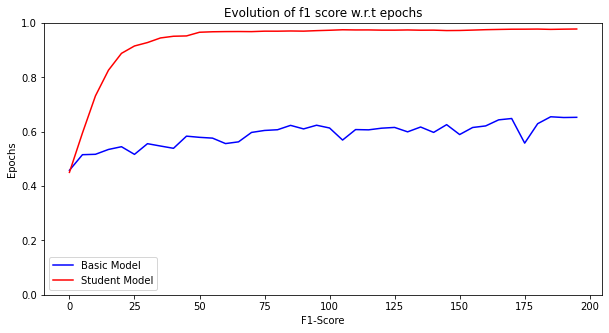

In [13]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))

def plot_f1_score(epoch_list, basic_model_scores, student_model_scores) :
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, basic_model_scores, 'b', label = "Basic Model")
    plt.plot(epoch_list, student_model_scores, 'r', label = "Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()
    
plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

### Question 1

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

**1.1. Answer**

Concerning the architecture of the proposed model, I was inspired by the paper (Velickovic et al, Graph Attention Networks, 2018) and the **Inductive Learning** method used on the PPI dataset (pages 7 of the paper). The architecture chosen is the following: batch size = 2, 200 epochs, Adap Optimizer, 2 GAT Layers with 256 features and 4 heads, 1 final GAT Layer for classification with 6 heads, ELU activation function, connections for the intermediate layers that pass through a linear layer whose output is summed with the output of the associated GAT layer "at the same depth level". 

I also have different architectures: 64, 128, 256 and 300 were tested for the number of features; 1, 2, 3 and 4 were tested for the number of heads; ELU, LeakyReLU and ReLU were tested for the activation functions; the same model without the linear connections was tested. As the number of features and attention heads increases, the computation time increases. The 3 activation functions show equivalent results, so ELU is retained. The model without the linear connections shows similar performance but converges less quickly and stably to the optimal solution.

Regarding the difference in performance between the use of the attention mechanism and the convolution layers, this can be explained by the fact that the attention mechanism allows to focus on certain nodes of the graph, while the convolution only focuses on the nodes in a certain neighbourhood. This allows GATs to extract more relevant and richer information for each node. Thus, with each iteration, the weights of the layers associated with the attention mechanism become more and more efficient at giving importance to the most important nodes.

**1.2. Answer**

According to Wikipedia, F1-score is a "*The F1 score is the harmonic mean of the precision and recall*". It is defined by :

$$F1-score = 2\frac{precision * recall}{precision + recall}$$

This metric is particularly interesting when the data labels are not balanced, because the number of true negatives is not detected. In other words, in some cases, this metric is better than accuracy in assessing the detection capacity of the model.

The F1-score obtained on the test set is **0.9879**. The result is convincing because the value is very close to 1, hence the model seems to generalize well on new data.

Compared to the state of the art, the result is very satisfactory as it is almost identical to the one proposed in the paper: **0.973** (Velickovic et al, Graph Attention Networks, page 8, 2018). However, it is below the method proposed in the paper **A Proposal of Multi-Layer Perceptron with Graph Gating Unit for Graph Representation Learning and its Application to Surrogate Model for FEM** (https://www.jstage.jst.go.jp/article/pjsai/JSAI2022/0/JSAI2022_1G4OS22a03/_pdf/-char/ja) which presents an F1-score of **0.9971**.

### Question 2

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

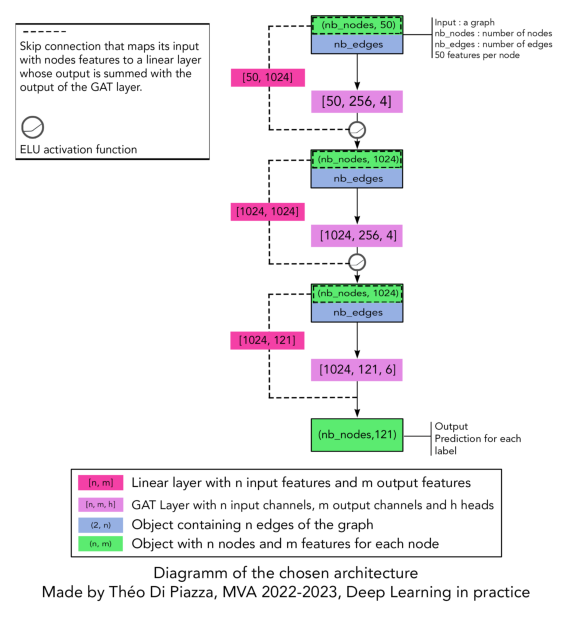

In [15]:
# Read the diagramm and display it
# please check that diagramm_architecture.png is in your working directory
plt.figure(figsize = (10,20))
img = mpimg.imread('diagramm_architecture.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

### Question 3

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ? 
2. Are there solutions to overcome it ? 
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

**3.1. Answer**

In the context of the Graph Neural Network, _oversmoothing_ is the fact that the model treats all nodes in the same way, resulting in an almost identical embedding for each node. Intuitively, the deeper the neural network layer, the more distant neighbours of each node are taken into account to generate the embedding. Thus, this can lead to a risk of treating all nodes identically. If nodes of different labels have similar embeddings, then this may lead to prediction errors in a classification task, for example.

**3.2. Answer**

A first solution that seems obvious is to train a network with a reasonable number of layers, i.e. not too many, as there is always a trade-off between model complexity and ability to generalise on new data.

Another solution can be to quantify this over-smoothing, as for example with the Group Distance Ratio metric (Kaixiong Zhou et al, 2020 - https://arxiv.org/abs/2006.06972), and to add this quantity to the Loss with a regularisation term, to try to minimise this over-smoothing. However, this requires more computational resources.

In the literature, (Kaixiong Zhou et al) introduces the Differentiable Group Normalization. This method consists of adding a layer that divides the nodes into different groups, normalizing them and obtaining additional embeding. This results in optimising the metric DGR by generating more similar embeddings within each group.

**3.3. Answer**

As for my model, I think it is robust to oversmoothing because it has the following qualities: it has been trained with a relatively small number of layers, it performs very well on the test sample and the metric used is the F1-score, which is an armonic average of precision and recall.

However, the model was only tested on the test data from the PPI dataset. These test data are different from the training dataset, but it would be useful to test the model on a completely different dataset in order to evaluate its ability to generalise. Because some similarities can be observed between the train and test sets of the same dataset.